# Explore here

In [59]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest
from pickle import dump
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

STEP 1: DATA COLLECTION

In [60]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv"
destination_path = "../data/raw/AB_NYC_2019.csv"

df = pd.read_csv(url)
df.to_csv(destination_path, index=False)

print("df is in:", destination_path)

df is in: ../data/raw/AB_NYC_2019.csv


In [61]:
df = pd.read_csv("../data/raw/AB_NYC_2019.csv")
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


STEP 2: EXPLORE & CLEAN DATA

In [62]:
# 2.1: DIMENSIONS ➞ (rows, columns)
df.shape

(48895, 16)

In [63]:
# 2.2: DATA TYPES & NON-NULL VALUES
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [64]:
df.isna().sum()[df.isna().sum()>0]

name                    16
host_name               21
last_review          10052
reviews_per_month    10052
dtype: int64

Observations:

From the previous info. we can see we have NA records:
- 'name': 16 Nulls → Considering this is the 'property name' we will fill NAs with 'fillna()' and later analyze if this has any impact when renting the properties.
- 'host_name': 21 Nulls → Considering each 'host_name' has its own 'host_is', we will check if they have other properties where the name appears. 
- 'last_review' and 'reviews_per_month': 10052 Nulls → They might be recently added properties which have not been rented yet.

Data types:
Numerical data: 10 columns
Categorical data: 6 columns

In [65]:
# 2.3: FIND & DELETE DUPLICATES
print(f"Nº of duplicated 'id' records is: {df['id'].duplicated().sum()}")

Nº of duplicated 'id' records is: 0


Observations:

Nº of 'id' duplicated records = 0 → all records should be unique.

In [66]:
# 2.4: DELETE IRRELEVANT INFO. & DEAL WITH NA VALUES
df.drop(columns=["id", "name", "host_name", "last_review", "latitude", "longitude"], axis = 1, inplace = True)
df.head()

,host_id,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2787,Brooklyn,Kensington,Private room,149,1,9,0.21,6,365
1,2845,Manhattan,Midtown,Entire home/apt,225,1,45,0.38,2,355
2,4632,Manhattan,Harlem,Private room,150,3,0,NaN,1,365
3,4869,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,4.64,1,194
4,7192,Manhattan,East Harlem,Entire home/apt,80,10,9,0.10,1,0


In [67]:
# Fill-in Null Values for 'reviews_per_month'
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

STEP 3: UNIVARIATE VARIABLE ANALYSIS

3.1: DIVE DATASET INTO CATEGORICAL AND NUMERICAL

In [68]:
# FEATURE TYPES
df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [69]:
# DIVIDE DF BY NUMERICAL AND CATEGORICAL
num = ['int64', 'float64']
cat = ['O']

df_num = df.select_dtypes(num)
df_cat = df.select_dtypes(cat)

In [70]:
df_cat.head()

,neighbourhood_group,neighbourhood,room_type
0,Brooklyn,Kensington,Private room
1,Manhattan,Midtown,Entire home/apt
2,Manhattan,Harlem,Private room
3,Brooklyn,Clinton Hill,Entire home/apt
4,Manhattan,East Harlem,Entire home/apt


3.2: CATEGORICAL VARIABLE ANALYSIS

/tmp/ipykernel_50720/2761241159.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis[0].set_xticklabels(axis[0].get_xticklabels(), rotation=45, color='blue')
/tmp/ipykernel_50720/2761241159.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis[2].set_xticklabels(axis[2].get_xticklabels(), rotation=45, color='blue')


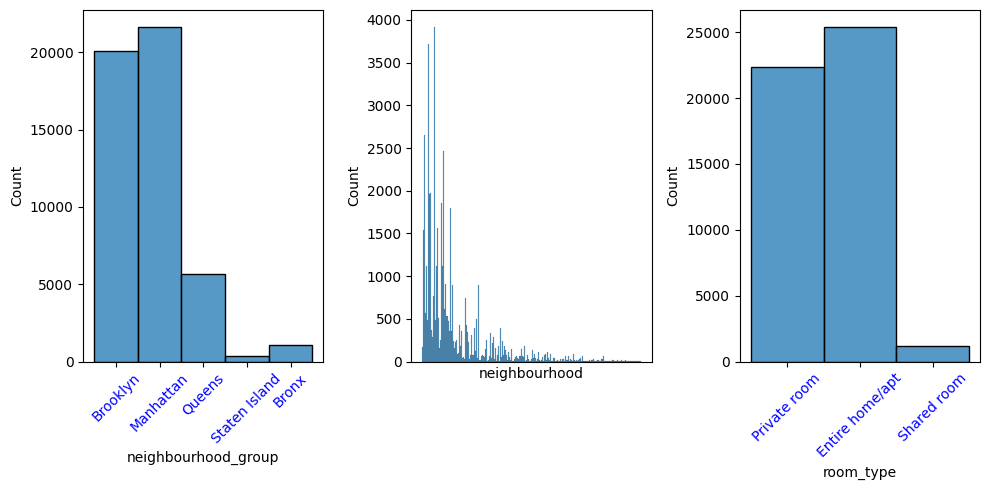

In [71]:
fig, axis = plt.subplots(1, 3, figsize=(10, 5))

# HISTOGRAM
sns.histplot(ax=axis[0], data=df_cat, x="neighbourhood_group")
axis[0].set_xticklabels(axis[0].get_xticklabels(), rotation=45, color='blue')
sns.histplot(ax=axis[1], data=df_cat, x="neighbourhood").set_xticks([])
sns.histplot(ax=axis[2], data=df_cat, x="room_type")
axis[2].set_xticklabels(axis[2].get_xticklabels(), rotation=45, color='blue')

plt.tight_layout()
plt.show()


Observations: 

- From 'neighbourhood_group' → Manhatan & Brooklyn are the top locations for Airbnb rentals.
- From 'room_type' → The majority of Airbnb listings are Entire Home/Apartments or Private Rooms, suggesting a focus on accomodating guests who prefere privacy.

3.3: NUMERICAL VARIABLE ANALYSIS

In [72]:
df_num.head()

,host_id,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2787,149,1,9,0.21,6,365
1,2845,225,1,45,0.38,2,355
2,4632,150,3,0,0.00,1,365
3,4869,89,1,270,4.64,1,194
4,7192,80,10,9,0.10,1,0


In [73]:
df_num['minimum_nights'].mean()

np.float64(7.029962163820431)

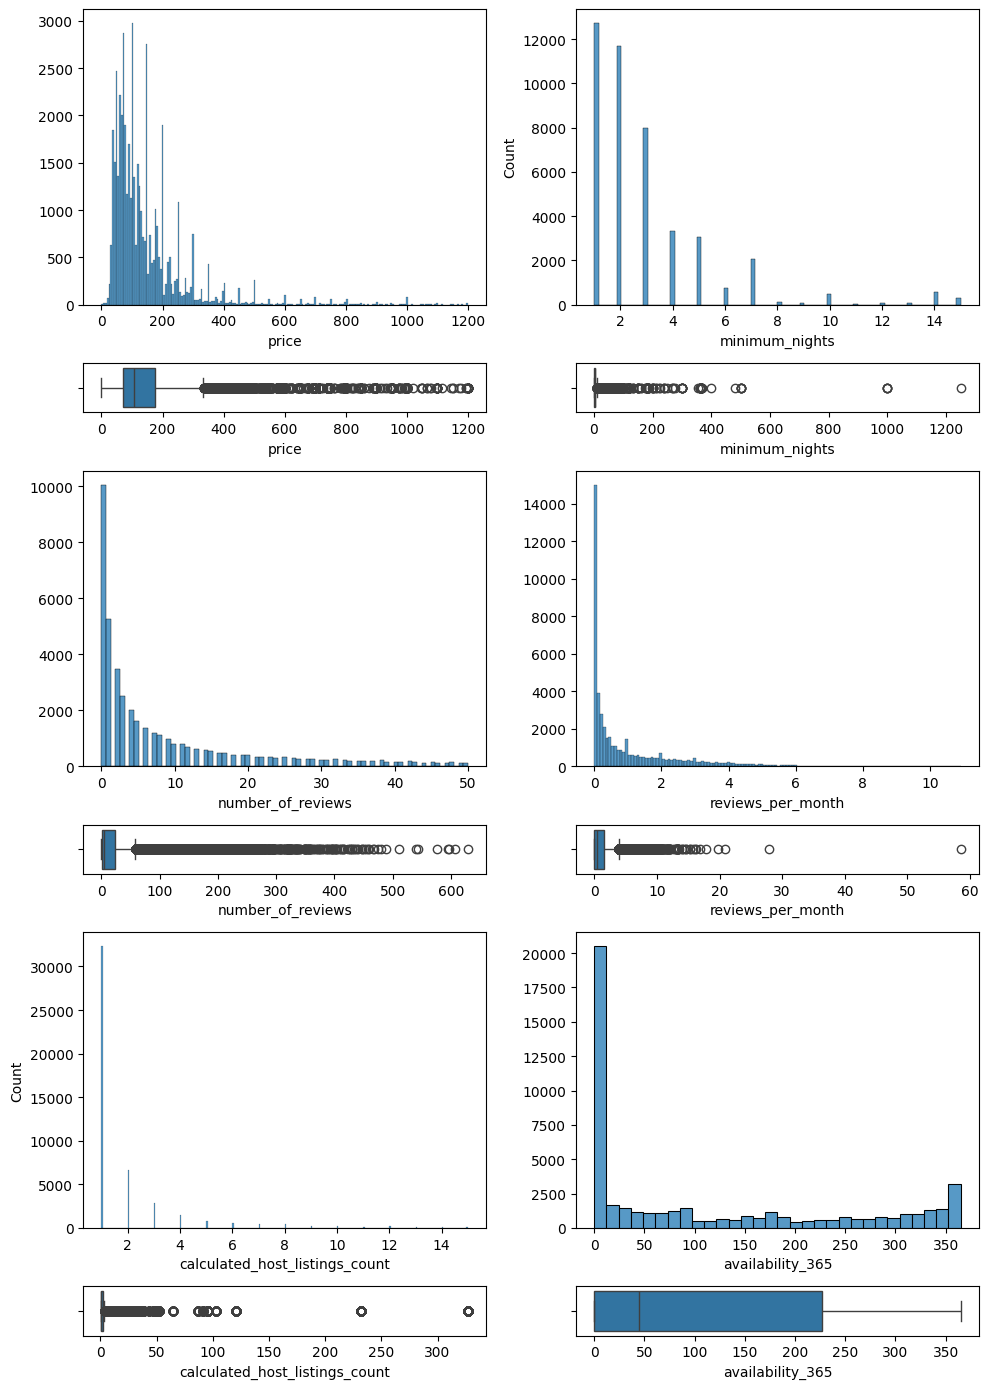

In [74]:
fig, ax = plt.subplots(6, 2, figsize = (10, 14), gridspec_kw = {"height_ratios": [6, 1, 6, 1, 6, 1]})

# 1sr row charts

sns.histplot(ax = ax[0,0], data = df_num[df_num['price']<1250], x='price').set(ylabel = None)
sns.boxplot(ax = ax[1,0], data = df_num[df_num['price']<1250], x='price')

sns.histplot(ax = ax[0,1], data = df_num[df_num['minimum_nights']<16], x='minimum_nights')
sns.boxplot(ax = ax[1,1], data = df_num, x='minimum_nights')

# 2nd row charts

sns.histplot(ax = ax[2,0], data = df_num[df_num['number_of_reviews']<51], x='number_of_reviews').set(ylabel = None)
sns.boxplot(ax = ax[3,0], data = df_num, x='number_of_reviews')

sns.histplot(ax = ax[2,1], data = df_num[df_num['reviews_per_month']<11], x='reviews_per_month').set(ylabel = None)
sns.boxplot(ax = ax[3,1], data = df_num, x='reviews_per_month')

# 3rd row charts

sns.histplot(ax = ax[4,0], data = df_num[df_num['calculated_host_listings_count']<16], x='calculated_host_listings_count')
sns.boxplot(ax = ax[5,0], data = df_num, x='calculated_host_listings_count')

sns.histplot(ax = ax[4,1], data = df_num, x='availability_365').set(ylabel = None)
sns.boxplot(ax = ax[5,1], data = df_num, x='availability_365')

plt.tight_layout()
plt.show()

STEP 4: MULTIVARIATE VARIABLE ANALYSIS

4.1 ENCODE CATEGORICAL VALUES AND SAVE JSON FILES

In [76]:
ng = list(df['neighbourhood_group'].unique())
neighbourhood_group_encoded = dict(zip(ng, list(range(len(ng)))))

with open('./enc/neighbourhood_group_encoded.json', 'w') as f:
    json.dump(neighbourhood_group_encoded, f)

In [77]:
n = list(df['neighbourhood'].unique())
neighbourhood_encoded = dict(zip(n, list(range(len(n)))))

with open('./enc/neighbourhood_encoded.json', 'w') as f:
    json.dump(neighbourhood_encoded, f)

In [78]:
rt = list(df['room_type'].unique())
room_type_encoded = dict(zip(rt, list(range(len(rt)))))

with open('./enc/room_type_encoded.json', 'w') as f:
    json.dump(room_type_encoded, f)

In [79]:
df_enc = df.copy()

In [80]:
df_enc['neighbourhood_group_encoded'] = df_enc['neighbourhood_group'].map(neighbourhood_group_encoded)
df_enc['neighbourhood_encoded'] = df_enc['neighbourhood'].map(neighbourhood_encoded)
df_enc['room_type_encoded'] = df_enc['room_type'].map(room_type_encoded)
df_enc.drop(columns=['neighbourhood_group', 'neighbourhood', 'room_type'], inplace=True)
df_enc.head()

,host_id,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_encoded,neighbourhood_encoded,room_type_encoded
0,2787,149,1,9,0.21,6,365,0,0,0
1,2845,225,1,45,0.38,2,355,1,1,1
2,4632,150,3,0,0.00,1,365,1,2,0
3,4869,89,1,270,4.64,1,194,0,3,1
4,7192,80,10,9,0.10,1,0,1,4,1


4.2: NUMERICAL CATEGORICAL ANALYSIS